In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [165]:
#!ls phase_chirp_data/210906* > filenames_210906.txt
filenames1 = !ls phase_chirp_data/210906_*_aom1_*
filenames2 = !ls phase_chirp_data/210906_*_aom2_*
filenames12 = !ls phase_chirp_data/210906_*_aom12_*

In [170]:
def prep_f(fn,threshold):
    """input: full path of filename & threshold value, outputs: dataframe"""
    df = pd.read_csv(fn,header=None,names=['timestamp','amplitude','phase/rad'])
    frame_size, T = list(df.iloc[0])[:2]
    frame_size = int(frame_size.split(' ')[-1])
    T = float(T.split(' ')[-1])
    #immediately there is a problem: timestamp only has 0.1ms resolution - breaks when samples are 50us apart
    df = df.iloc[3:]
    df['t/us'] = np.linspace(0,T,frame_size+1)
    df = df.set_index('t/us').iloc[:-1]
    df = df.drop('timestamp',axis='columns') #redundant col
    df = df.applymap(lambda x: float(x)) #convert str to float
    #only consider values above certain threshold
    df = df[df['amplitude']>threshold]
    return df

In [172]:
aoms1 = []
for fn in filenames1:
    aoms1.append(prep_f(fn,9.1e-4))

From data analysis when AOM1 is dark, the mean value is ~6.3e-4, stdev of 9.3e-5. hence threshold is set to 3 stdevs away: 9.09e-4.
When AOM2 is dark, mean value is ~1.6e-4, stdev of 8.2e-5. threshold is 3 stdevs away: 4.1e-4

When 2 AOMs are dark, the mean value is ~1.1e-4, with stdev of 5.4e-5. threshold set to 3 stdevs away: 2.7e-4

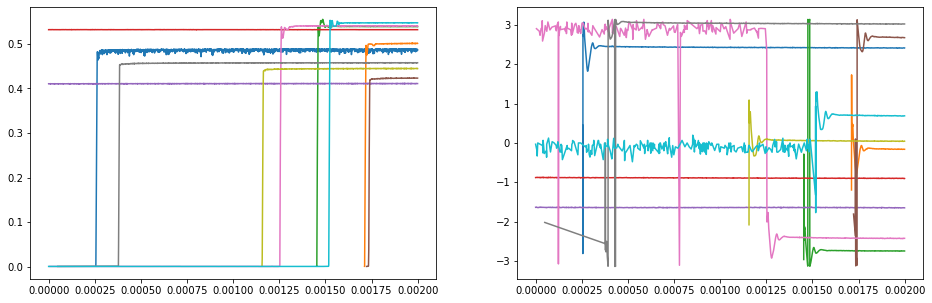

In [174]:
fig, [ax0,ax1] = plt.subplots(1,2,figsize=(16,5))
for df in aoms1:
    ax0.plot(df['amplitude'])
    ax1.plot(df['phase/rad'])
plt.show()

In [109]:
thres = 1e-3
df['amplitude'] > thres

t/us
0.000000e+00    False
5.000000e-07    False
1.000000e-06    False
1.500000e-06    False
2.000000e-06    False
                ...  
1.997500e-03     True
1.998000e-03     True
1.998500e-03     True
1.999000e-03     True
1.999500e-03     True
Name: amplitude, Length: 4000, dtype: bool

### Long timescales (10s) 

In [235]:
from allantools import adev
from scipy.signal import welch

In [178]:
files = !ls long_noswitch/*

In [195]:
beat_10s = []
for fn in files:
    df = pd.read_csv(fn,header=1)
    frame_size,T = 2000000, 10
    #sampling time in seconds
    df['t/s'] = np.linspace(0,T,frame_size+1)
    df = df.set_index('t/s').iloc[:-1]
    df = df.drop('timestamp',axis='columns') #redundant col
    df = df.applymap(lambda x: float(x)) #convert str to float
    beat_10s.append(df)

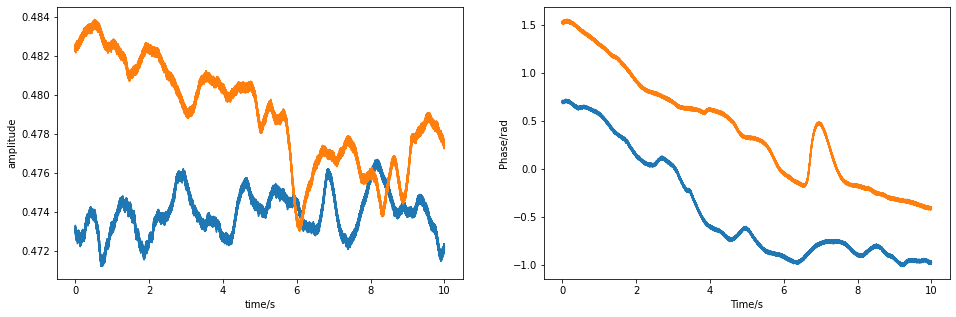

In [289]:
fig, [ax0,ax1] = plt.subplots(1,2,figsize=(16,5))
for df in beat_10s:
    ax0.plot(df[' amplitude'])
    ax0.set_ylabel('amplitude')
    ax0.set_xlabel('time/s')
    ax1.plot(df[' phase/rad'])
    ax1.set_ylabel('Phase/rad')
    ax1.set_xlabel('Time/s')
plt.show()

In [305]:
amp_adevs, freq_adevs = [],[]
for df in beat_10s:
    fs = 200e3
    amp, phs = df[' amplitude'], df[' phase/rad']
    amp_adevs.append(adev(np.array(amp),rate=fs,data_type='freq',taus=np.logspace(-7,1,200)))
    freq_adevs.append(adev(np.array(phs),rate=fs,data_type='phase',taus=np.logspace(-7,1,200)))

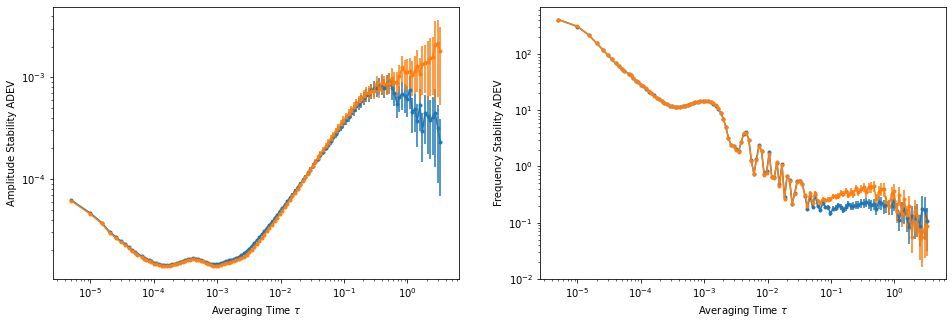

In [306]:
fig, [ax0,ax1] = plt.subplots(1,2,figsize=(16,5))
ax0.set_yscale('log')
ax0.set_xscale('log')
ax0.set_ylabel('Amplitude Stability ADEV')
ax0.set_xlabel(r'Averaging Time $\tau$')
ax1.set_yscale('log')
ax1.set_xscale('log')
ax1.set_ylabel('Frequency Stability ADEV')
ax1.set_xlabel(r'Averaging Time $\tau$')

for aa,ff in zip(amp_adevs,freq_adevs):
    ax0.errorbar(*aa[:3],fmt='.-')
    ax1.errorbar(*ff[:3],fmt='.-')

Note that Allan variance, when looking at a (fractional) frequency timeseries $y_i$, is given by:
$$ \sigma_y^2(\tau) = \frac{1}{2(M-1)} \sum_{i=1}^{M-1} [\bar y_{i+1}-\bar y_i]^2 $$
for $M$ samples for a sampling time interval of $\tau$. If given phase data $x_i$, then $y_i = (x_{i}-x_{i-1})/\tau$ from first backward difference, giving the Allan variance in the expression:
$$ \sigma_y^2(\tau) = \frac{1}{2(N-2)\tau^2} \sum_{i=1}^{N-2} [\bar x_{i+2}-2\bar x_{i+1}+\bar x_i]^2 $$
for $N=M+1$ phase values. The inclusion of the $1/\tau^2$, so $1/\tau$ for ADEV, indicates that a random walk in phase actually corresponds to a white noise in frequency. A random run (drift) in phase corresponds to a flicker noise in frequency.

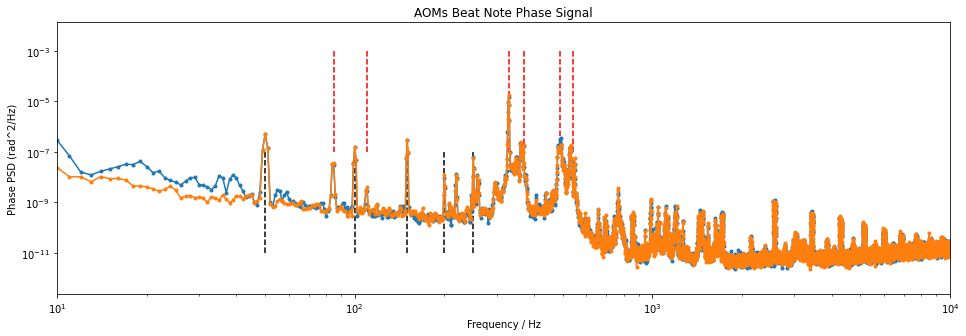

In [292]:
plt.figure(figsize=(16,5))
for df in beat_10s:
    ph = np.array(df[' phase/rad'])
    psd = welch(ph,fs=200e3,nperseg=200e3)
    plt.plot(*psd,'.-')
plt.yscale('log')
plt.xscale('log')
plt.xlim(1e1,1e4)
minmax = min(psd[1]),max(psd[1])
plt.vlines([50,100,150,200,250],1e-11,1e-7,colors='k',ls='--')
plt.vlines([85,110,330,370,490,540],1e-7,1e-3,colors='r',ls='--')
plt.title('AOMs Beat Note Phase Signal')
plt.ylabel('Phase PSD (rad^2/Hz)')
plt.xlabel('Frequency / Hz')
plt.show()

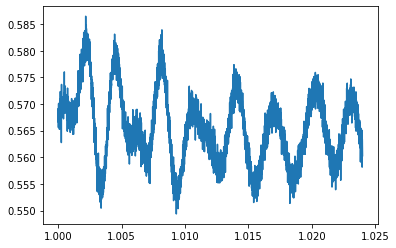

In [302]:
df = beat_10s[0]
tstart, tend = 1, 1+24e-3
xstart, xend = int(tstart*200e3), int(tend*200e3)
plt.plot(df[' phase/rad'].iloc[xstart:xend])

In [299]:
xstart

200000